In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

model_rf_reload_pkl = pickle.load(open('model_rf.pkl', 'rb'))

### Attack

In this example here, we're going to see what a model can reveal and try to infer what's the best way to explore it. 

The only assumption here it's that we know that it's a credit scoring model that will predict if someone it's going to pay or not; but we do not have any previous knowledge about the model at all. 


#### Estimators
My first choice seeing this `.pkl` file was to try to check if this model it is an Scikit-Learn object. 

I've tried some commands to see the attributes, but my intellisense gave me all the parameters and attributes without even load the Scikit-Learn. 

In that way, I'll examine the number of estimators of this model. 

In [2]:
print(f'Number of Estimators: {len(model_rf_reload_pkl.estimators_)}')

Number of Estimators: 5


With 5 estimators, I can infer that this model it's not so complex and my life will be quite simple if those estimators did not have a huge discrepancy between them. 

I'll check now, the characteristics of each one of those estimators. 

In [3]:
for estimator in model_rf_reload_pkl.estimators_:
    print(f'{estimator}\n')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1608637542, splitter='best')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1273642419, splitter='best')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto'

What I'm seeing here from those estimators:
- As the estimators are using the best Splitter (`splitter=”best”`), it means that the attacker should consider that once knowing the impurity of each column, the attack becomes simpler. It occurs due to the fact a feature with a high impurity won't be in the higher levels of the tree; i.e. those very high impurity features will be on the lower levels.  


- Another piece of information given here it's the Depth of the tree (`max_depth=3`). For that case, the attacker knows that won't be a big deal to generate a feasible search space to search in the attack; or the attacker can infer that maybe there's some [_underfitting_](https://chemicalstatistician.wordpress.com/2014/03/19/machine-learning-lesson-of-the-day-overfitting-and-underfitting/) in this model and because of that it's not needed a higher level of precision in the parameter combination set.  


- With 100 records as the minimum amount of samples in the leaf node  (`min_samples_leaf=100`), the attacker knows that each terminal node has at least 100 records with _some level of similarity_. In other words, it means that once that the attacker knows _one leaf node_ he/she can explore it with slightly modifications in that search space.  

Now let's take a look at a single estimator. 

In [4]:
# Extract single tree (Estimator 4)
estimator = model_rf_reload_pkl.estimators_[4]
print(f'Number of Features: {estimator.n_features_}')

Number of Features: 10


The attacker knows that this model it's not highly dimensional, meaning that maybe the parameter search space it's not too large. But we do not know if those variables are continuous or discrete. 

#### Relative Importances

Let's enlist the variables and see their relative importance. 

In [5]:
features_list = [str(x + 0) for x in range(estimator.n_features_)]
features_list

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

I'll create a function to check all estimators features to have a better picture of what's the parameters importances.

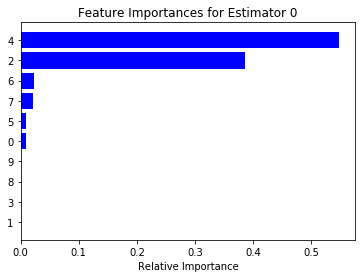

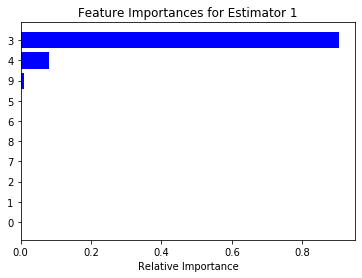

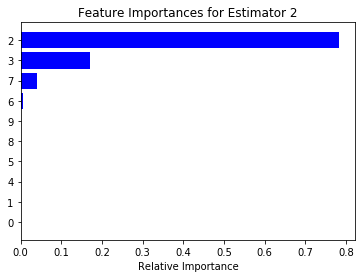

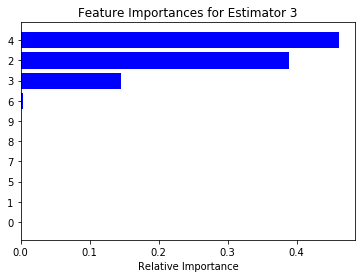

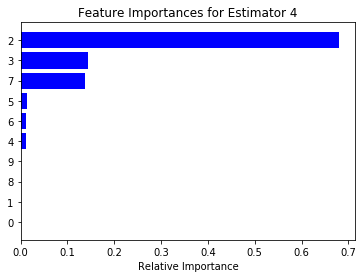

In [6]:
def get_relative_importances_by_estimator(model):
    number_estimators = len(model.estimators_)
    for i in range(0, number_estimators):
        estimator = model.estimators_[i]
        importances = estimator.feature_importances_
        indices = np.argsort(importances)
        plt.figure(1)
        plt.title(f'Feature Importances for Estimator {i}')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), indices)
        plt.xlabel('Relative Importance')
        plt.show()
    
    
get_relative_importances_by_estimator(model=model_rf_reload_pkl)

Attacks in most of the time it's about `a)` **search space** (in case of brute force) or `b)` **specific knowledge** where to attack, and this figure gives us those things. 

A potential Attacker now knows:

- The model relies mainly upon the features `2, 3` and `4`;  


- The features `0, 1, 9`, and `8` are almost irrelevant. It means that those features do not need to be explored.  


This makes the search space for attacks quite simpler because the attacker knows that the model has critical features that it relies upon, and some parameters that can be dismissed.


#### Decision Tree itself 

Let's generate the graph for all estimators trees and check the general rules of this tree. 

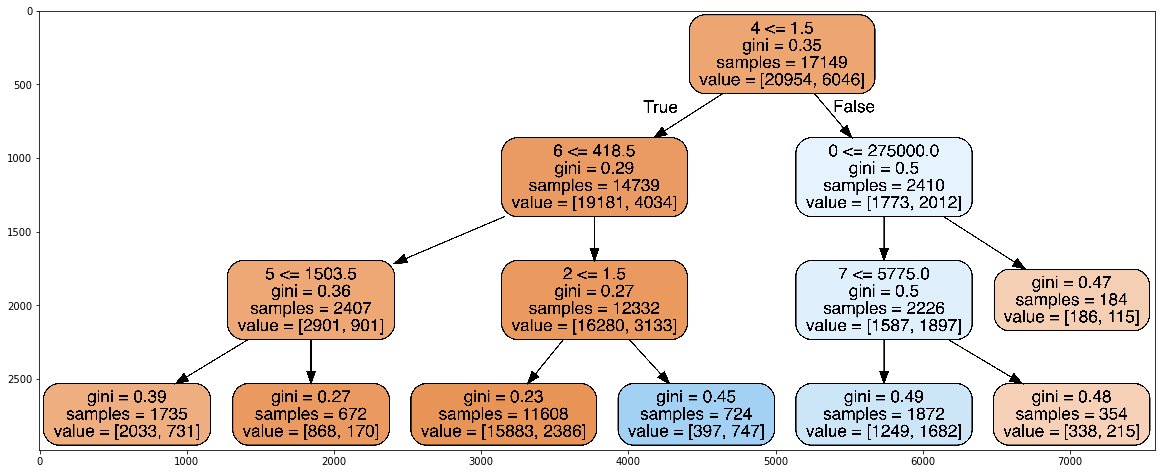

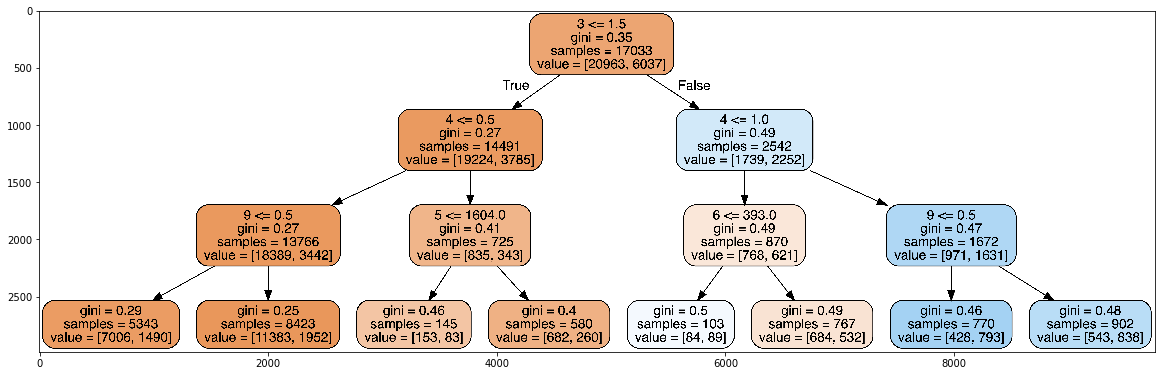

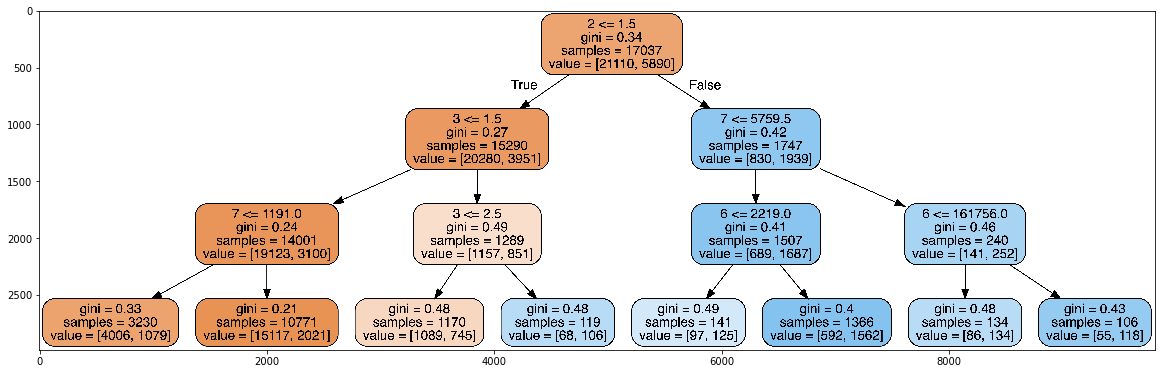

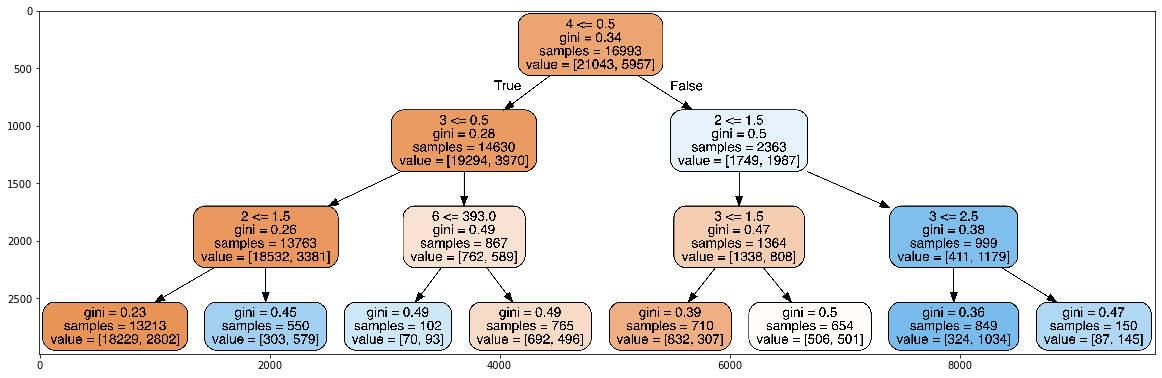

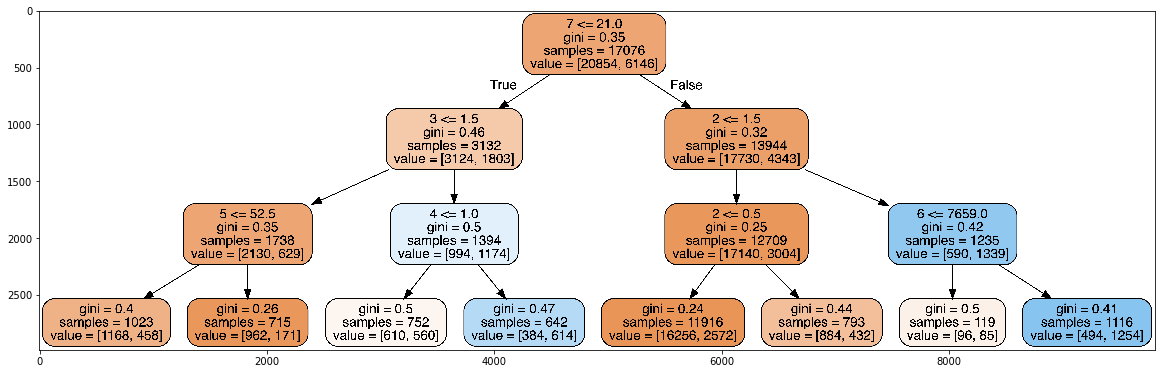

In [7]:
import matplotlib
from sklearn.tree import export_graphviz
from subprocess import call
matplotlib.rc('figure', figsize=(20, 10))

def get_estimators_trees_graphs(model):
    number_estimators = len(model.estimators_)
    for i in range(0, number_estimators):
        estimator = model.estimators_[i]
                
        export_graphviz(estimator, out_file='tree.dot', 
                       feature_names = features_list,
                       rounded = True, proportion = False, 
                       precision = 2, filled = True)

        # Convert to png using system command (requires Graphviz)
        call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

        # Display in jupyter 
        pil_image = Image.open('tree.png')
        np_image_array = np.asarray(pil_image)
        plt.imshow(np_image_array)
        plt.show()
    
    
get_estimators_trees_graphs(model=model_rf_reload_pkl)    

With those trees graphs of the credit default model available, some pieces of information it's available to the potential attackers, like:  

- The big reliance in the `2, 3, 4` fields;
- Clear thresholds in the splits that leads automatically to the `false` state in some estimators (ex: `7 <= 21` in the estimator `4`)

## Countermeasures 
- If it's possible, avoid have those model artefacts public, not only in repos but in filesystems as well;  


- If it's possible, avoid to use models that can be reversed-engineered like decision trees. The same for NLP models that countains word embeddings matrices available in attributes and/or methods.